In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
try:
    import empyrical as emp
except:
    emp = None
import tushare as ts
import time
import random
# from concurrent.futures import ProcessPoolExecutor

from common.log import *
from common.config import Config
from spider.spider_nasdaq import Spider_nasdaq
from spider.spider_coinmarketcap import Spider_coinmarketcap

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from pandas_highcharts.core import serialize
from pandas_highcharts.display import display_charts

CONF = Config('../conf/secret.yaml').data[0]
ts_token = CONF['TUSHARE']['TOKEN']
ts.set_token(ts_token)
pro = ts.pro_api()

CONF = Config().data[0]
MONGODB = CONF['MONGODB']
NASDAQ = CONF['NASDAQ']
CRYPTOCURRENCY = CONF['CRYPTOCURRENCY']
CRYPTOCURRENCY = list(CRYPTOCURRENCY.keys())
NASDAQ100 = CONF['NASDAQ100']
# HS300 = list(ts.get_hs300s()['code'])
# HS300_df = pd.read_csv('../database/HS300IDX_ALL.csv')
# HS300 = list(set(HS300_df.con_code))
# HS300 = [x.split('.')[0] for x in HS300]
ZZ500_df = pd.read_csv('../database/ZZ500IDX_ALL.csv')
ZZ500 = list(set(ZZ500_df.con_code))
ZZ500 = [x.split('.')[0] for x in ZZ500]

BENCHMARK = '399300'
BENCHMARK = '000905'
TARGET = ZZ500

ALL_TARGET = TARGET[:]
len(ALL_TARGET)

pd

<module 'pandas' from 'd:\\python3\\lib\\site-packages\\pandas\\__init__.py'>

In [2]:
%%time

IS_DOWNLOAD_DATA = False

for symbol in TARGET + [BENCHMARK]:
    if not IS_DOWNLOAD_DATA:
        break
        
    print(symbol)

    # 指数
    if symbol in ['399300', '000905', '000016']:
        df = ts.get_k_data(code=symbol, index=True, start='2005-01-01', end=time.strftime('%Y-%m-%d'))
        datafile = '../database/market/%s.csv' % symbol
        df.to_csv(datafile, index=False, encoding='utf-8')
        
    # ETF / 股票
    else:
        df = ts.get_k_data(code=symbol, ktype='D', autype='qfq', index=False, start='2005-01-01', end=time.strftime('%Y-%m-%d'))
        datafile = '../database/market/%s.csv' % symbol
        df.to_csv(datafile, index=False, encoding='utf-8')
        time.sleep(1)

#         if symbol.startswith('00') or symbol.startswith('30'):
#             temp_symbol = '%s.SZ' % symbol
#         elif symbol.startswith('60'):
#             temp_symbol = '%s.SH' % symbol
#         df = pro.daily_basic(ts_code=temp_symbol, start_date='20050101', end=time.strftime('%Y%m%d'))
#         datafile = '../database/market/%s_pro_daily_basic.csv' % symbol
#         df.to_csv(datafile, index=False, encoding='utf-8')
        
#     print(datafile)
    time.sleep(1)

Wall time: 0 ns


In [3]:
%%time

### 时间设置
start_date = '2013-01-01'
end_date = '2018-11-01'
# end_date = time.strftime('%Y-%m-%d')

TURTLE_POS = 50
### Turtle System One - Short
TURTLE_SHORT_BUY_N = 20
TURTLE_SHORT_SELL_N = 20
### Turtle System Two - Long
TURTLE_LONG_BUY_N = 60
TURTLE_LONG_SELL_N = 20

### 业务设置
IS_HAPPYMONEY = False
IS_TAX = False
IS_SLIPPAGE = False
IS_RANDOM_BUY = False
IS_FILTER = False
IS_MARKETUP = False
IS_UNIQUE = False
IS_BUYBENCHMARK = True
IS_SHOWBUYLIST = True
START_MONEY = 100000
HAPPY_MONEY = 0
PROPERTY = START_MONEY
CASH = START_MONEY


Wall time: 0 ns


In [4]:
%%time

stock_df_dict = {}

for symbol in TARGET + [BENCHMARK]:
    stock_data_file = '../database/market/%s.csv' % symbol
    try:
        stock_df = pd.read_csv(stock_data_file)
    except:
        print(symbol)
        continue

    # 筛选字段
    stock_df = stock_df.loc[:, ['date', 'open', 'close']]

    # 去掉Nasdaq行情首行的当天行情
    if symbol in NASDAQ100:
        stock_df = stock_df.drop([0])

    # 抛弃空值异常值
    stock_df.dropna(axis=0, how='any', inplace=True)

    # 格式化日期
    # 445 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    stock_df = stock_df.assign(date=pd.to_datetime(stock_df['date']))  # need .index.to_period('D')

    # 用日期作索引，日期升序排序
    # 95.1 µs ± 1.58 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
    if symbol in NASDAQ100 or symbol in CRYPTOCURRENCY:
        stock_df = stock_df[::-1]
    stock_df.set_index(['date'], inplace=True)
    stock_df.index = stock_df.index.to_period('D')

    # 计算每天涨跌幅
    stock_df['o_pct_chg'] = stock_df.open.pct_change(1)
#     stock_df['pre_close'] = stock_df.close.shift(1)
#     stock_df['c_o_pct_chg'] = (stock_df.open - stock_df.pre_close) / stock_df.pre_close
    stock_df['c_o_pct_chg'] = (stock_df.open - stock_df.close.shift(1)) / stock_df.close.shift(1)
    
    # Turtle指标
#     stock_df['TR1'] = abs(stock_df['high'] - stock_df['low'])
#     stock_df['TR2'] = abs(stock_df['high'] - stock_df['close'].shift())
#     stock_df['TR3'] = abs(stock_df['low'] - stock_df['close'].shift())
#     stock_df['TR'] = stock_df[['TR1', 'TR2', 'TR3']].max(axis=1)
#     stock_df['N'] = stock_df['TR'].rolling(20).mean()
#     stock_df['UNIT'] = (0.01 * START_MONEY) / (stock_df['N'])
#     stock_df['ROLLING_%d_MAX' % TURTLE_SHORT_BUY_N] = stock_df['open'].rolling(TURTLE_SHORT_BUY_N).max()
#     stock_df['ROLLING_%d_MIN' % TURTLE_SHORT_SELL_N] = stock_df['open'].rolling(TURTLE_SHORT_SELL_N).min()
    stock_df['ROLLING_%d_MAX' % TURTLE_LONG_BUY_N] = stock_df['open'].rolling(TURTLE_LONG_BUY_N).max()
    stock_df['ROLLING_%d_MIN' % TURTLE_LONG_SELL_N] = stock_df['open'].rolling(TURTLE_LONG_SELL_N).min()
#     stock_df['EWMA'] = stock_df['open'].ewm(alpha=0.1, adjust=False).mean()
#     stock_df['MA360'] = stock_df['open'].rolling(360).mean()
#     stock_df['MA250'] = stock_df['open'].rolling(250).mean()
    stock_df['MA180'] = stock_df['open'].rolling(180).mean()
    stock_df['MA90'] = stock_df['open'].rolling(90).mean()
    stock_df['MA60'] = stock_df['open'].rolling(60).mean()
    stock_df['MA30'] = stock_df['open'].rolling(30).mean()
    stock_df['MA10'] = stock_df['open'].rolling(10).mean()
    
#     df = '../database/market/%s_pro_daily_basic.csv' % symbol
#     try:
#         df = pd.read_csv(df)
#         df = df[::-1]
#         df = df.assign(trade_date=pd.to_datetime(df['trade_date'], format='%Y%m%d'))
#         df.set_index(['trade_date'], inplace=True)
#         df.index = df.index.to_period('D')
#         stock_df = pd.concat([stock_df, df['pe']], axis=1)
#     except:
#         print(symbol)
#         stock_df['pe'] = 9999
    
    # 减少数据
    # stock_df = stock_df['2016-01-01':]
    stock_df.dropna(how='any', inplace=True)
#     stock_df.drop(columns=['volume', 'TR1', 'TR2', 'TR3'], inplace=True)
    
    stock_df_dict[symbol] = stock_df

Wall time: 1min 31s


In [5]:
'''抽查数据'''

stock_df_dict[BENCHMARK].head(2)
stock_df_dict[BENCHMARK].tail(2)
# '000866' in HSALL
# stock_df_dict['163407']
# pro.index_weight(index_code='399300.SZ', trade_date='', start_date='20150101', end_date='20150301')

# df = ts.get_k_data(code='601299', ktype='D', autype='qfq', index=False, start='2005-01-01', end=time.strftime('%Y-%m-%d'))
# df
# stock_df_dict['601299'].head(2)

# df = stock_df_dict[BENCHMARK].iloc[:].copy()
# df.columns
# df.reset_index(drop=False, inplace=True)
# df = df.astype(dtype={'date': 'datetime64[ns]'})
# df['date'] = df['date'].apply(lambda x: x.to_timestamp().to_datetime64())
# df.set_index('date', inplace=True)
# ax = df.plot(kind='line', y='close', label='test', linewidth=1, grid=True)
# display_charts(df, chart_type='stock', kind='line', 
#                y=['open', 'ROLLING_%d_MAX' % TURTLE_LONG_BUY_N, 'ROLLING_%d_MIN' % TURTLE_LONG_SELL_N, 'MA30', 'MA60', 'MA180'], 
#                figsize=(900, 600))

'抽查数据'

,open,close,o_pct_chg,c_o_pct_chg,ROLLING_60_MAX,ROLLING_20_MIN,MA180,MA90,MA60,MA30,MA10
date,,,,,,,,,,,
2007-10-12,5005.56,4891.39,-0.020569,0.000012,5169.23,4692.4,3721.648778,4372.817222,4599.955333,4965.412000,5058.226
2007-10-15,4896.83,4890.60,-0.021722,0.001112,5169.23,4692.4,3738.400778,4383.873222,4620.654833,4968.558667,5043.879


,open,close,o_pct_chg,c_o_pct_chg,ROLLING_60_MAX,ROLLING_20_MIN,MA180,MA90,MA60,MA30,MA10
date,,,,,,,,,,,
2018-11-07,4437.72,4415.14,0.002340,-0.000086,5043.89,3958.45,5343.099056,4796.800000,4630.626833,4413.232000,4291.779
2018-11-08,4442.66,4382.33,0.001113,0.006233,5043.89,3958.45,5335.525167,4788.833778,4622.324833,4405.522333,4323.626


In [6]:
'''用基准数据来存储策略数据'''
show_df = None
show_df = stock_df_dict[BENCHMARK].copy()
show_df.loc[:, 'CASH'] = START_MONEY
show_df.loc[:, 'PROPERTY'] = START_MONEY

'用基准数据来存储策略数据'

In [7]:
%%time
# %xmode

'''简易海龟策略，唐安奇通道突破信号，平均分头寸'''

PROPERTY = START_MONEY
CASH = START_MONEY
IS_MARKETUP = True
IS_RANDOM_BUY = False
count_day = 0
yesterday = None
miss_buy_short = 0
miss_buy_long = 0
# TARGET = []

order_df = None
order_df = pd.DataFrame(columns=[
    'buy_date', 'symbol', 'buy_count', 'buy_price', 'buy_reason', 'sell_date', 'sell_price', 'sell_reason', 'profit', 'cash', 'property'
])

ops_df = None
ops_df = pd.DataFrame(columns=[
    'ops_date', 'ops', 'symbol', 'count', 'price', 'reason', 'profit'
])

# 时间序列
for today in pd.period_range(start=start_date, end=end_date, freq='D'):
    count_day += 1
    
    # 每年年初计算回报率
    if today.dayofyear == 1 or today == (pd.to_datetime(end_date)).to_period(freq='D'):
        if today.dayofyear == 1:
            lastyear_firstday = pd.to_datetime('%d-01-01' % (today.year - 1))
        else:
            lastyear_firstday = pd.to_datetime('%d-01-01' % today.year)
        lastyear_firstday = lastyear_firstday.to_period(freq='D')
#         print(today, show_df.iloc[0].name, show_df[:today].iloc[-1].PROPERTY)
        if today > show_df.iloc[0].name:
            today_property = show_df[:today].iloc[-2].PROPERTY
#             print(show_df[:today].iloc[-1])
        else:
            today_property = show_df.iloc[0].PROPERTY
        if lastyear_firstday > show_df.iloc[0].name:
            lastyear_firstday_property = show_df[:lastyear_firstday].iloc[-1].PROPERTY
        else:
            lastyear_firstday_property = show_df.iloc[0].PROPERTY
#         lastyear_return = round((today_property - lastyear_firstday_property) / lastyear_firstday_property, 4)
        lastyear_return = '%.3f' % ((today_property - lastyear_firstday_property) / lastyear_firstday_property)
        print(lastyear_firstday, today, int(lastyear_firstday_property), int(today_property), lastyear_return)
    
    # 每年筛股
    if IS_FILTER and (today.dayofyear == 1 or count_day == 1):
        TARGET = ALL_TARGET[:]
        benchmark_lastyear = stock_df_dict[BENCHMARK][:today]
        
        # 不到一年（250个交易日）
        if len(benchmark_lastyear) < 250:
            continue
        
        # 筛选过滤
        benchmark_return_lastyear = benchmark_lastyear.iloc[-1].open / benchmark_lastyear.iloc[-250].open
        for symbol, stock_df in stock_df_dict.items():
            try:
                return_lastyear = stock_df[:today].iloc[-1].open / stock_df[:today].iloc[-250].open
                if return_lastyear < benchmark_return_lastyear:
                    TARGET.remove(symbol)
#                     print(symbol, return_lastyear)
            except:
                TARGET.remove(symbol)
                pass
        print(today, 'TARGET after filter', len(TARGET))
        
    
    if yesterday is None:
        yesterday = today
        continue

    # 日期不在基准交易日，则不交易
    if today not in stock_df_dict[BENCHMARK].index:
        continue
    
    # 更新指数成分
    if BENCHMARK == '399300':
        NEW_TARGET_df = HS300_df[HS300_df.trade_date == int(today.strftime('%Y%m%d'))]
        if len(NEW_TARGET_df) != 0:
            NEW_TARGET = [x.split('.')[0] for x in list(NEW_TARGET_df.con_code)]
            if sorted(NEW_TARGET) != sorted(TARGET):
                print(today, 'CHANGE TARGET', len(NEW_TARGET_df))
                TARGET = NEW_TARGET
        else:
            pass

    if BENCHMARK == '000905':
        NEW_TARGET_df = ZZ500_df[ZZ500_df.trade_date == int(today.strftime('%Y%m%d'))]
        if len(NEW_TARGET_df) != 0:
            NEW_TARGET = [x.split('.')[0] for x in list(NEW_TARGET_df.con_code)]
            if sorted(NEW_TARGET) != sorted(TARGET):
                print(today, 'CHANGE TARGET', len(NEW_TARGET_df))
                TARGET = NEW_TARGET
        else:
            pass
            
    # 突破下行趋势，清仓退出
    order_arr = order_df.to_records(index=False)
    if len(order_arr[(order_arr.buy_count > 0) & (order_arr.sell_price == 0)] ) != 0:
        is_sell = False
        for idx in order_df[(order_df['buy_count'] > 0) & (order_df['sell_price'] == 0)].index:
            cur_order = order_df.loc[idx]
            symbol = cur_order['symbol']
            if today not in stock_df_dict[symbol].index or yesterday not in stock_df_dict[symbol].index:
                continue
            today_market = stock_df_dict[symbol].loc[today]
            if today_market.c_o_pct_chg < -0.1:
#                 print(today, symbol, '跌停板，卖不掉')
                continue
            if cur_order.buy_reason == 'SHORT':
                is_sell = (today_market.open <= today_market['ROLLING_%d_MIN' % TURTLE_SHORT_SELL_N])
            if cur_order.buy_reason == 'LONG':
                is_sell = (today_market.open <= today_market['ROLLING_%d_MIN' % TURTLE_LONG_SELL_N])
            if is_sell:
                CASH += cur_order.buy_count * today_market.open
                order_df.loc[idx, 'sell_date'] = today
                order_df.loc[idx, 'sell_price'] = today_market.open
                order_df.loc[idx, 'sell_reason'] = 'EXIT'
                order_df.loc[idx, 'profit'] = \
                    (today_market.open - cur_order.buy_price) * cur_order.buy_count
#                 print(today, '退出', stock_df_dict[symbol].loc[today, 'open'], CASH)
                
                ops_df = ops_df.append(
                    {
                        'ops_date': today,
                        'ops': 'SELL',
                        'symbol': symbol,
                        'count': cur_order.buy_count,
                        'price': today_market.open,
                        'reason': cur_order.buy_reason,
                        'profit': (today_market.open - cur_order.buy_price) * cur_order.buy_count,
                    },
                    ignore_index=True
                )

    # 开心止盈，倍数止盈
    if IS_HAPPYMONEY:        
        if PROPERTY > START_MONEY * 2 and CASH > START_MONEY:
            HAPPY_MONEY += START_MONEY
            PROPERTY -= START_MONEY
            CASH -= START_MONEY
    
    benchmark_today_market = stock_df_dict[BENCHMARK].loc[today]
#     try:
#         benchmark_yesterday_market = stock_df_dict[BENCHMARK].loc[:today].iloc[-2]
#     except:
#         benchmark_yesterday_market = stock_df_dict[BENCHMARK].loc[:today].iloc[-1]
    buy_list = []
    
    # 遍历标的，判断和执行买入
    for symbol in TARGET:
        if symbol not in stock_df_dict:
            continue

        # 趋势交易，只在好行情时买入
        if IS_MARKETUP:
            if benchmark_today_market.MA60 < benchmark_today_market.MA180:
#             if benchmark_today_market.MA90 < benchmark_today_market.MA180:
                break
        
        # 是否购买基准
        if not IS_BUYBENCHMARK and symbol == BENCHMARK:
            continue
        
        if today not in stock_df_dict[symbol].index or yesterday not in stock_df_dict[symbol].index:
            continue
            
        # TIME TEST
        # DELETED

        today_market = stock_df_dict[symbol].loc[today]

        # 突破上行趋势，就买一份
#         order_arr = order_df.to_records(index=False)
        is_buy = False
        if True:
            if today_market.open >= today_market['ROLLING_%d_MAX' % TURTLE_LONG_BUY_N]:
                is_buy = True
                buy_reason = 'LONG'
            elif False and today_market.open >= today_market['ROLLING_%d_MAX' % TURTLE_SHORT_BUY_N]:
                is_buy = True
                buy_reason = 'SHORT'

        if is_buy:
            buy_list.append(symbol)
            
    if IS_RANDOM_BUY:
        random.shuffle(buy_list)
    else:
        tmp_list = []
        for symbol in buy_list:
            try:
                return_lastyear = stock_df_dict[symbol][:today].iloc[-1].open / stock_df_dict[symbol][:today].iloc[-250].open
            except:
                return_lastyear = stock_df_dict[symbol][:today].iloc[-1].open / stock_df_dict[symbol][:today].iloc[1].open
            tmp_list.append((return_lastyear, symbol))
            try:
                pe = stock_df_dict[symbol][:today].iloc[-1].pe
            except:
                pe = 9999
#             tmp_list.append((pe, symbol))
        tmp_list = sorted(tmp_list, reverse=False)
        buy_list = [x[1] for x in tmp_list if x[0]>1]
#         buy_list = [x[1] for x in tmp_list]
#         random.shuffle(buy_list)
    
    order_arr = order_df.to_records(index=False)
    for symbol in buy_list:    
        if IS_UNIQUE:
            if len(order_arr[(order_arr.symbol == symbol) & (order_arr.buy_count > 0) & (order_arr.sell_price == 0)] ) != 0:
                continue

        today_market = stock_df_dict[symbol].loc[today]
        buy_count = 0
                
        # 滑点
        if IS_SLIPPAGE:
            buy_price = today_market.open * (1 + random.randint(0, 20) / 1000)
        else:
            buy_price = today_market.open
                
        # 按份数买
        if CASH >= PROPERTY / TURTLE_POS:
            buy_count = int((PROPERTY / TURTLE_POS) / buy_price)

        # 指数购买，满仓干
#         buy_count = int(CASH / buy_price)

        if buy_count > 0:
            if today_market.c_o_pct_chg > 0.1:
#                 print(today, symbol, '涨停板，买不进')
                continue
            
        if buy_count > 0:
            CASH -= buy_count * buy_price
#             print(today, '建仓', buy_count, stock_df_dict[symbol].loc[today, 'open'], CASH)
            order_df = order_df.append(
                {
                    'buy_date': today,
                    'symbol': symbol,
                    'buy_count': buy_count,
                    'buy_price': today_market.open,
                    'buy_reason': buy_reason,
                    'sell_date': pd.np.nan,
                    'sell_price': 0,
                    'profit': 0,
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )
            ops_df = ops_df.append(
                {
                    'ops_date': today,
                    'ops': 'BUY',
                    'symbol': symbol,
                    'count': buy_count,
                    'price': buy_price,
                    'reason': buy_reason,
                    'profit': 0,
                },
                ignore_index=True
            )
        else:
            if buy_reason == 'LONG':
                miss_buy_long += 1
            elif buy_reason == 'SHORT':
                miss_buy_short += 1
            
    # 每天盘点财产
    # 大盘下行时，闲钱进行T+0无风险投资，如货币基金
#     if benchmark_today_market.MA60 < benchmark_today_market.MA180:
#         CASH = CASH * (1 + 0.04 / 365)
#     CASH = CASH * (1 + 0.03 / 365)
    show_df.loc[today, 'CASH'] = CASH
    PROPERTY = CASH + \
        sum(
            [
                stock_df_dict[order_df.loc[idx, 'symbol']][:today].iloc[-1].open * order_df.loc[idx, 'buy_count'] \
                for idx in order_df.loc[order_df['sell_price']==0].index
            ]
        )
    show_df.loc[today, 'PROPERTY'] = PROPERTY

    yesterday = today
    
#     print(today)


    
# 最后一天，清仓
order_arr = order_df.to_records(index=False)
for idx in order_df[order_df['sell_price'] == 0].index:
    cur_order = order_df.loc[idx]
    symbol = cur_order['symbol']
    today_market = stock_df_dict[symbol][:today].iloc[-1]
    CASH += cur_order.buy_count * today_market.open
    order_df.loc[idx, 'sell_date'] = today
    order_df.loc[idx, 'sell_price'] = today_market.open
    order_df.loc[idx, 'sell_reason'] = 'EXIT'
    order_df.loc[idx, 'profit'] = \
        (today_market.open - cur_order.buy_price) * cur_order.buy_count
    ops_df = ops_df.append(
        {
            'ops_date': today,
            'ops': 'SELL',
            'symbol': symbol,
            'count': cur_order.buy_count,
            'price': today_market.open,
            'reason': cur_order.buy_reason,
            'profit': (today_market.open - cur_order.buy_price) * cur_order.buy_count,
        },
        ignore_index=True
    )


print('START_MONEY', START_MONEY)
print('CASH', CASH)
print('HAPPY_MONEY', HAPPY_MONEY)
print('PROPERTY', PROPERTY)

s_p = stock_df_dict[BENCHMARK][start_date:].iloc[0].open
e_p = stock_df_dict[BENCHMARK][:end_date].iloc[-1].open
print('BENCHMARK', s_p, e_p, e_p / s_p)

show_df['PROPERTY_TT'] = show_df['PROPERTY']

2012-01-01 2013-01-01 100000 100000 0.000
2013-01-31 CHANGE TARGET 500
2013-04-26 CHANGE TARGET 500
2013-07-31 CHANGE TARGET 500
2013-12-31 CHANGE TARGET 500
2013-01-01 2014-01-01 100000 95630 -0.044
2014-06-30 CHANGE TARGET 500
2014-12-31 CHANGE TARGET 500
2014-01-01 2015-01-01 95442 124686 0.306
2015-06-30 CHANGE TARGET 500
2015-12-31 CHANGE TARGET 500
2015-01-01 2016-01-01 123601 120027 -0.029
2016-06-30 CHANGE TARGET 500
2016-12-30 CHANGE TARGET 500
2016-01-01 2017-01-01 120238 120130 -0.001
2017-01-26 CHANGE TARGET 500
2017-02-28 CHANGE TARGET 500
2017-06-30 CHANGE TARGET 500
2017-12-29 CHANGE TARGET 500
2017-01-01 2018-01-01 120354 121714 0.011
2018-06-29 CHANGE TARGET 500
2018-01-01 2018-11-01 121105 106963 -0.117
START_MONEY 100000
CASH 106963.846
HAPPY_MONEY 0
PROPERTY 106963.846
BENCHMARK 3297.04 4299.46 1.30403634775
Wall time: 3min 58s


In [8]:
order_df
ops_df

,buy_date,symbol,buy_count,buy_price,buy_reason,sell_date,sell_price,sell_reason,profit,cash,property
0,2013-03-05,002479,217,9.212,LONG,2013-04-15,8.2,EXIT,-219.604,98000.996,100000
1,2013-03-05,600635,642,3.112,LONG,2013-03-29,2.869,EXIT,-156.006,96003.092,100000
2,2013-03-05,603366,280,7.136,LONG,2013-03-29,6.605,EXIT,-148.68,94005.012,100000
3,2013-03-05,000566,370,5.395,LONG,2013-03-20,5.076,EXIT,-118.03,92008.862,100000
4,2013-03-05,600258,208,9.584,LONG,2013-03-29,8.73,EXIT,-177.632,90015.390,100000
5,2013-03-05,002332,368,5.421,LONG,2013-04-08,4.882,EXIT,-198.352,88020.462,100000
6,2013-03-05,601388,720,2.774,LONG,2013-03-18,2.413,EXIT,-259.92,86023.182,100000
7,2013-03-05,002678,385,5.186,LONG,2013-03-29,5.042,EXIT,-55.44,84026.572,100000
8,2013-03-05,600161,191,10.440,LONG,2013-05-24,9.664,EXIT,-148.216,82032.532,100000
9,2013-03-05,600645,70,28.500,LONG,2013-04-08,24.13,EXIT,-305.9,80037.532,100000


,ops_date,ops,symbol,count,price,reason,profit
0,2013-03-05,BUY,002479,217,9.212,LONG,0
1,2013-03-05,BUY,600635,642,3.112,LONG,0
2,2013-03-05,BUY,603366,280,7.136,LONG,0
3,2013-03-05,BUY,000566,370,5.395,LONG,0
4,2013-03-05,BUY,600258,208,9.584,LONG,0
5,2013-03-05,BUY,002332,368,5.421,LONG,0
6,2013-03-05,BUY,601388,720,2.774,LONG,0
7,2013-03-05,BUY,002678,385,5.186,LONG,0
8,2013-03-05,BUY,600161,191,10.440,LONG,0
9,2013-03-05,BUY,600645,70,28.500,LONG,0


In [9]:
df = show_df.dropna(how='any', inplace=False).copy()
df = df.loc[start_date:end_date]
algo = df['PROPERTY'].pct_change()
benchmark = df.open.pct_change()

ALL_DAYS = len(df)
FREECASH_DAY = len(df[df['CASH'] > (df['PROPERTY'] / TURTLE_POS)])

output_str = ''
# for y in range(int(start_date.split('-')[0]), int(end_date.split('-')[0]) + 1, 1):
#     y_df = df.loc['%d-01-01' % y:'%d-01-01' % (y + 1)]
#     y_algo = y_df['PROPERTY'].pct_change()
#     y_benchmark = y_df.open.pct_change()
#     result = '%d-%d,%.3f,%.3f,%.3f,%.3f' % (
#         y, y + 1, emp.cum_returns(y_algo)[-1], emp.cum_returns(y_benchmark)[-1], emp.max_drawdown(y_algo), emp.max_drawdown(y_benchmark)
#     )
#     output_str += result
#     output_str += ';'

df = order_df.copy()
df['pro_pct'] = (df.sell_price - df.buy_price) / df.buy_price
df = df.loc[:, ['symbol', 'pro_pct']]
df = df.groupby(by='symbol').sum()
buy_stock_count = len(df)
    
score_sr = pd.Series({
        'START': start_date,
        'END': end_date,
        'TURTLE_POS': TURTLE_POS,
        'ROLLMAX': 0,
        'ROLLMIN': 0,
        'MA_SHORT': 60,
        'MA_LONG': 180,
        'X_DAY_RETURN': 250,
        'ORDER': len(order_df),
        'STOCK': buy_stock_count,
        'RETURN': emp.cum_returns(algo)[-1],
        'MAXDROPDOWN': emp.max_drawdown(algo),
        'WINRATE': len(order_df[order_df.profit > 0]) / len(order_df[order_df.profit != 0]),
        'annual_return': emp.annual_return(algo),
        'annual_volatility': emp.annual_volatility(algo, period='daily'),
        'calmar_ratio': emp.calmar_ratio(algo),
        'sharpe_ratio': emp.sharpe_ratio(returns=algo),
        'alpha': emp.alpha(returns=algo, factor_returns=benchmark, risk_free=0.00),
        'beta': emp.beta(returns=algo, factor_returns=benchmark, risk_free=0.00),
        'ALL_DAYS': ALL_DAYS,
        'FREECASH_DAY': FREECASH_DAY,
        'MISS_SIGNAL': miss_buy_long,
        'RET_PER_YEAR': output_str,
    })

score_sr

ALL_DAYS                   1417
END                  2018-11-01
FREECASH_DAY                732
MAXDROPDOWN            -0.55837
MA_LONG                     180
MA_SHORT                     60
MISS_SIGNAL               24923
ORDER                      1127
RETURN                0.0696385
RET_PER_YEAR                   
ROLLMAX                       0
ROLLMIN                       0
START                2013-01-01
STOCK                       476
TURTLE_POS                   50
WINRATE                0.363556
X_DAY_RETURN                250
alpha               -0.00921359
annual_return         0.0120443
annual_volatility      0.219773
beta                   0.487498
calmar_ratio          0.0215705
sharpe_ratio           0.165873
dtype: object

In [10]:
%%time
# %xmode

'''均线突破策略，平均分头寸'''

PROPERTY = START_MONEY
CASH = START_MONEY
IS_MARKETUP = False
IS_RANDOM_BUY = False
IS_UNIQUE = False
count_day = 0
yesterday = None
miss_buy_short = 0
miss_buy_long = 0

order_df = None
order_df = pd.DataFrame(columns=[
    'buy_date', 'symbol', 'buy_count', 'buy_price', 'buy_reason', 'sell_date', 'sell_price', 'sell_reason', 'profit', 'cash', 'property'
])

ops_df = None
ops_df = pd.DataFrame(columns=[
    'ops_date', 'ops', 'symbol', 'count', 'price', 'reason', 'profit'
])

# 时间序列
for today in pd.period_range(start=start_date, end=end_date, freq='D'):
    count_day += 1
    
    # 每年年初计算回报率
    if today.dayofyear == 1 or today == (pd.to_datetime(end_date)).to_period(freq='D'):
        if today.dayofyear == 1:
            lastyear_firstday = pd.to_datetime('%d-01-01' % (today.year - 1))
        else:
            lastyear_firstday = pd.to_datetime('%d-01-01' % today.year)
        lastyear_firstday = lastyear_firstday.to_period(freq='D')
#         print(today, show_df.iloc[0].name, show_df[:today].iloc[-1].PROPERTY)
        if today > show_df.iloc[0].name:
            today_property = show_df[:today].iloc[-2].PROPERTY
#             print(show_df[:today].iloc[-1])
        else:
            today_property = show_df.iloc[0].PROPERTY
        if lastyear_firstday > show_df.iloc[0].name:
            lastyear_firstday_property = show_df[:lastyear_firstday].iloc[-1].PROPERTY
        else:
            lastyear_firstday_property = show_df.iloc[0].PROPERTY
#         lastyear_return = round((today_property - lastyear_firstday_property) / lastyear_firstday_property, 4)
        lastyear_return = '%.3f' % ((today_property - lastyear_firstday_property) / lastyear_firstday_property)
        print(lastyear_firstday, today, int(lastyear_firstday_property), int(today_property), lastyear_return)
    
    # 每年筛股
    if IS_FILTER and (today.dayofyear == 1 or count_day == 1):
        TARGET = ALL_TARGET[:]
        benchmark_lastyear = stock_df_dict[BENCHMARK][:today]
        
        # 不到一年（250个交易日）
        if len(benchmark_lastyear) < 250:
            continue
        
        # 筛选过滤
        benchmark_return_lastyear = benchmark_lastyear.iloc[-1].open / benchmark_lastyear.iloc[-250].open
        for symbol, stock_df in stock_df_dict.items():
            try:
                return_lastyear = stock_df[:today].iloc[-1].open / stock_df[:today].iloc[-250].open
                if return_lastyear < benchmark_return_lastyear:
                    TARGET.remove(symbol)
#                     print(symbol, return_lastyear)
            except:
                TARGET.remove(symbol)
                pass
        print(today, 'TARGET after filter', len(TARGET))
        
    
    if yesterday is None:
        yesterday = today
        continue

    # 日期不在基准交易日，则不交易
    if today not in stock_df_dict[BENCHMARK].index:
        continue
        
    # 更新指数成分
    if BENCHMARK == '399300':
        NEW_TARGET_df = HS300_df[HS300_df.trade_date == int(today.strftime('%Y%m%d'))]
        if len(NEW_TARGET_df) != 0:
            NEW_TARGET = [x.split('.')[0] for x in list(NEW_TARGET_df.con_code)]
            if sorted(NEW_TARGET) != sorted(TARGET):
                print(today, 'CHANGE TARGET', len(NEW_TARGET_df))
                TARGET = NEW_TARGET
        else:
            pass

    if BENCHMARK == '000905':
        NEW_TARGET_df = ZZ500_df[ZZ500_df.trade_date == int(today.strftime('%Y%m%d'))]
        if len(NEW_TARGET_df) != 0:
            NEW_TARGET = [x.split('.')[0] for x in list(NEW_TARGET_df.con_code)]
            if sorted(NEW_TARGET) != sorted(TARGET):
                print(today, 'CHANGE TARGET', len(NEW_TARGET_df))
                TARGET = NEW_TARGET
        else:
            pass
            
    # 突破下行趋势，清仓退出
    order_arr = order_df.to_records(index=False)
    if len(order_arr[(order_arr.buy_count > 0) & (order_arr.sell_price == 0)] ) != 0:
        is_sell = False
        for idx in order_df[(order_df['buy_count'] > 0) & (order_df['sell_price'] == 0)].index:
            cur_order = order_df.loc[idx]
            symbol = cur_order['symbol']
            if today not in stock_df_dict[symbol].index or yesterday not in stock_df_dict[symbol].index:
                continue
            today_market = stock_df_dict[symbol].loc[today]
            if today_market.c_o_pct_chg < -0.1:
#                 print(today, symbol, '跌停板，卖不掉')
                continue
            if cur_order.buy_reason == 'SHORT':
                is_sell = (today_market.open <= today_market['ROLLING_%d_MIN' % TURTLE_SHORT_SELL_N])
            if cur_order.buy_reason == 'LONG':
#                 is_sell = (today_market.open <= today_market['ROLLING_%d_MIN' % TURTLE_LONG_SELL_N])
                is_sell = (today_market.MA30 <= today_market.MA60)
#                 is_sell = (today_market.MA180 <= today_market.MA250)
            if is_sell:
                CASH += cur_order.buy_count * today_market.open
                order_df.loc[idx, 'sell_date'] = today
                order_df.loc[idx, 'sell_price'] = today_market.open
                order_df.loc[idx, 'sell_reason'] = 'EXIT'
                order_df.loc[idx, 'profit'] = \
                    (today_market.open - cur_order.buy_price) * cur_order.buy_count
#                 print(today, '退出', stock_df_dict[symbol].loc[today, 'open'], CASH)
                
                ops_df = ops_df.append(
                    {
                        'ops_date': today,
                        'ops': 'SELL',
                        'symbol': symbol,
                        'count': cur_order.buy_count,
                        'price': today_market.open,
                        'reason': cur_order.buy_reason,
                        'profit': (today_market.open - cur_order.buy_price) * cur_order.buy_count,
                    },
                    ignore_index=True
                )

    # 开心止盈，倍数止盈
    if IS_HAPPYMONEY:        
        if PROPERTY > START_MONEY * 2 and CASH > START_MONEY:
            HAPPY_MONEY += START_MONEY
            PROPERTY -= START_MONEY
            CASH -= START_MONEY
    
    benchmark_today_market = stock_df_dict[BENCHMARK].loc[today]
#     try:
#         benchmark_yesterday_market = stock_df_dict[BENCHMARK].loc[:today].iloc[-2]
#     except:
#         benchmark_yesterday_market = stock_df_dict[BENCHMARK].loc[:today].iloc[-1]
    buy_list = []
    
    # 遍历标的，判断和执行买入
    for symbol in TARGET:
        if symbol not in stock_df_dict:
            continue
        
        # 趋势交易，只在好行情时买入
        if IS_MARKETUP:
#             if benchmark_today_market.MA60 < benchmark_today_market.MA180:
            if benchmark_today_market.MA90 < benchmark_today_market.MA180:
#             if benchmark_today_market.MA180 < benchmark_today_market.MA250:
#             if benchmark_today_market.MA180 < benchmark_today_market.MA360:
#             if benchmark_today_market.MA90 < benchmark_today_market.MA250 and benchmark_today_market.MA180 < benchmark_today_market.MA250:
                break
        
        # 是否购买基准
        if not IS_BUYBENCHMARK and symbol == BENCHMARK:
            continue
        
        if today not in stock_df_dict[symbol].index or yesterday not in stock_df_dict[symbol].index:
            continue
            
        # TIME TEST
        # DELETED

        today_market = stock_df_dict[symbol].loc[today]
        yesterday_market = stock_df_dict[symbol].loc[:today].iloc[-2]

        # 突破上行趋势，就买一份
        is_buy = False
        if True:
#             if today_market.MA90 >= today_market.MA180 and yesterday_market.MA90 <= yesterday_market.MA180:
            if today_market.MA30 >= today_market.MA60:
#             if today_market.MA180 > today_market.MA250:
                is_buy = True
                buy_reason = 'LONG'

        if is_buy:
            buy_list.append(symbol)
            
    if IS_RANDOM_BUY:
        random.shuffle(buy_list)
    else:
        tmp_list = []
        for symbol in buy_list:
            lastyear_today = pd.to_datetime('%d-%d-01' % (today.year - 1, today.month))
            if len(stock_df_dict[symbol][lastyear_today:today]) < 100:
#                 print('%s %d 停牌' % (symbol, len(stock_df_dict[symbol][lastyear_today:today])))
#                 continue
                pass
            try:
                return_lastyear = stock_df_dict[symbol][:today].iloc[-1].open / stock_df_dict[symbol][:today].iloc[-250].open
            except:
                return_lastyear = stock_df_dict[symbol][:today].iloc[-1].open / stock_df_dict[symbol][:today].iloc[1].open
            tmp_list.append((return_lastyear, symbol))
        tmp_list = sorted(tmp_list, reverse=False)
#         print(today, tmp_list)
        buy_list = [x[1] for x in tmp_list if x[0]>1]
#         buy_list = [x[1] for x in tmp_list]
#         random.shuffle(buy_list)
    
    order_arr = order_df.to_records(index=False)
    for symbol in buy_list:    
        if IS_UNIQUE:
            if len(order_arr[(order_arr.symbol == symbol) & (order_arr.buy_count > 0) & (order_arr.sell_price == 0)] ) != 0:
                continue

        today_market = stock_df_dict[symbol].loc[today]
        buy_count = 0
                
        # 滑点
        if IS_SLIPPAGE:
            buy_price = today_market.open * (1 + random.randint(0, 20) / 1000)
        else:
            buy_price = today_market.open
                
        # 按份数买
        if CASH >= PROPERTY / TURTLE_POS:
            buy_count = int((PROPERTY / TURTLE_POS) / buy_price)

        # 指数购买，满仓干
#         buy_count = int(CASH / buy_price)

        if buy_count > 0:
            if today_market.c_o_pct_chg > 0.1:
#                 print(today, symbol, '涨停板，买不进')
                continue
            
        if buy_count > 0:
            CASH -= buy_count * buy_price
#             print(today, '建仓', buy_count, stock_df_dict[symbol].loc[today, 'open'], CASH)
            order_df = order_df.append(
                {
                    'buy_date': today,
                    'symbol': symbol,
                    'buy_count': buy_count,
                    'buy_price': today_market.open,
                    'buy_reason': buy_reason,
                    'sell_date': pd.np.nan,
                    'sell_price': 0,
                    'profit': 0,
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )
            ops_df = ops_df.append(
                {
                    'ops_date': today,
                    'ops': 'BUY',
                    'symbol': symbol,
                    'count': buy_count,
                    'price': buy_price,
                    'reason': buy_reason,
                    'profit': 0,
                },
                ignore_index=True
            )
        else:
            if buy_reason == 'LONG':
                miss_buy_long += 1
            elif buy_reason == 'SHORT':
                miss_buy_short += 1
            
    # 每天盘点财产
    # 大盘下行时，闲钱进行T+0无风险投资，如货币基金
#     if benchmark_today_market.MA60 < benchmark_today_market.MA180:
#         CASH = CASH * (1 + 0.04 / 365)
#     CASH = CASH * (1 + 0.03 / 365)
    show_df.loc[today, 'CASH'] = CASH
    PROPERTY = CASH + \
        sum(
            [
                stock_df_dict[order_df.loc[idx, 'symbol']][:today].iloc[-1].open * order_df.loc[idx, 'buy_count'] \
                for idx in order_df.loc[order_df['sell_price']==0].index
            ]
        )
    show_df.loc[today, 'PROPERTY'] = PROPERTY

    yesterday = today
    
#     print(today)
    
# 最后一天，清仓
order_arr = order_df.to_records(index=False)
for idx in order_df[order_df['sell_price'] == 0].index:
    cur_order = order_df.loc[idx]
    symbol = cur_order['symbol']
    today_market = stock_df_dict[symbol][:today].iloc[-1]
    CASH += cur_order.buy_count * today_market.open
    order_df.loc[idx, 'sell_date'] = today
    order_df.loc[idx, 'sell_price'] = today_market.open
    order_df.loc[idx, 'sell_reason'] = 'EXIT'
    order_df.loc[idx, 'profit'] = \
        (today_market.open - cur_order.buy_price) * cur_order.buy_count
    ops_df = ops_df.append(
        {
            'ops_date': today,
            'ops': 'SELL',
            'symbol': symbol,
            'count': cur_order.buy_count,
            'price': today_market.open,
            'reason': cur_order.buy_reason,
            'profit': (today_market.open - cur_order.buy_price) * cur_order.buy_count,
        },
        ignore_index=True
    )


print('START_MONEY', START_MONEY)
print('CASH', CASH)
print('HAPPY_MONEY', HAPPY_MONEY)
print('PROPERTY', PROPERTY)

s_p = stock_df_dict[BENCHMARK][start_date:].iloc[0].open
e_p = stock_df_dict[BENCHMARK][:end_date].iloc[-1].open
print('BENCHMARK', s_p, e_p, e_p / s_p)

show_df['PROPERTY_MA'] = show_df['PROPERTY']

2012-01-01 2013-01-01 100000 100000 0.000
2013-01-31 CHANGE TARGET 500
2013-04-26 CHANGE TARGET 500
2013-07-31 CHANGE TARGET 500
2013-12-31 CHANGE TARGET 500
2013-01-01 2014-01-01 100000 110462 0.105
2014-06-30 CHANGE TARGET 500
2014-12-31 CHANGE TARGET 500
2014-01-01 2015-01-01 111351 133820 0.202
2015-06-30 CHANGE TARGET 500
2015-12-31 CHANGE TARGET 500
2015-01-01 2016-01-01 132363 161952 0.224
2016-06-30 CHANGE TARGET 500
2016-12-30 CHANGE TARGET 500
2016-01-01 2017-01-01 164863 109727 -0.334
2017-01-26 CHANGE TARGET 500
2017-02-28 CHANGE TARGET 500
2017-06-30 CHANGE TARGET 500
2017-12-29 CHANGE TARGET 500
2017-01-01 2018-01-01 109807 102038 -0.071
2018-06-29 CHANGE TARGET 500
2018-01-01 2018-11-01 102168 77511 -0.241
START_MONEY 100000
CASH 79620.037
HAPPY_MONEY 0
PROPERTY 79620.037
BENCHMARK 3297.04 4299.46 1.30403634775
Wall time: 15min 37s


In [11]:
order_df

,buy_date,symbol,buy_count,buy_price,buy_reason,sell_date,sell_price,sell_reason,profit,cash,property
0,2013-01-07,600717,374,5.342,LONG,2013-03-29,5.227,EXIT,-43.01,98002.092,100000
1,2013-01-07,601872,808,2.475,LONG,2013-03-27,2.417,EXIT,-46.864,96002.292,100000
2,2013-01-07,000667,934,2.141,LONG,2013-03-21,2.054,EXIT,-81.258,94002.598,100000
3,2013-01-07,000400,164,12.183,LONG,2013-04-08,12.673,EXIT,80.36,92004.586,100000
4,2013-01-07,600017,716,2.792,LONG,2013-03-22,2.743,EXIT,-35.084,90005.514,100000
5,2013-01-07,600458,165,12.049,LONG,2013-03-13,10.495,EXIT,-256.41,88017.429,100000
6,2013-01-07,600642,559,3.573,LONG,2013-04-26,3.63,EXIT,31.863,86020.122,100000
7,2013-01-07,600291,304,6.558,LONG,2013-04-23,8.981,EXIT,736.592,84026.490,100000
8,2013-01-07,300159,525,3.807,LONG,2013-03-18,3.663,EXIT,-75.6,82027.815,100000
9,2013-01-07,002665,764,2.617,LONG,2013-04-09,2.284,EXIT,-254.412,80028.427,100000


In [12]:
df = show_df.dropna(how='any', inplace=False).copy()
df = df.loc[start_date:end_date]
algo = df['PROPERTY'].pct_change()
benchmark = df.open.pct_change()

ALL_DAYS = len(df)
FREECASH_DAY = len(df[df['CASH'] > (df['PROPERTY'] / TURTLE_POS)])

output_str = ''
# for y in range(int(start_date.split('-')[0]), int(end_date.split('-')[0]) + 1, 1):
#     y_df = df.loc['%d-01-01' % y:'%d-01-01' % (y + 1)]
#     y_algo = y_df['PROPERTY'].pct_change()
#     y_benchmark = y_df.open.pct_change()
#     result = '%d-%d,%.3f,%.3f,%.3f,%.3f' % (
#         y, y + 1, emp.cum_returns(y_algo)[-1], emp.cum_returns(y_benchmark)[-1], emp.max_drawdown(y_algo), emp.max_drawdown(y_benchmark)
#     )
#     output_str += result
#     output_str += ';'

df = order_df.copy()
df['pro_pct'] = (df.sell_price - df.buy_price) / df.buy_price
df = df.loc[:, ['symbol', 'pro_pct']]
df = df.groupby(by='symbol').sum()
buy_stock_count = len(df)
    
score_sr = pd.Series({
        'START': start_date,
        'END': end_date,
        'TURTLE_POS': TURTLE_POS,
        'ROLLMAX': 0,
        'ROLLMIN': 0,
        'MA_SHORT': 60,
        'MA_LONG': 180,
        'X_DAY_RETURN': 250,
        'ORDER': len(order_df),
        'STOCK': buy_stock_count,
        'RETURN': emp.cum_returns(algo)[-1],
        'MAXDROPDOWN': emp.max_drawdown(algo),
        'WINRATE': len(order_df[order_df.profit > 0]) / len(order_df[order_df.profit != 0]),
        'annual_return': emp.annual_return(algo),
        'annual_volatility': emp.annual_volatility(algo, period='daily'),
        'calmar_ratio': emp.calmar_ratio(algo),
        'sharpe_ratio': emp.sharpe_ratio(returns=algo),
        'alpha': emp.alpha(returns=algo, factor_returns=benchmark, risk_free=0.00),
        'beta': emp.beta(returns=algo, factor_returns=benchmark, risk_free=0.00),
        'ALL_DAYS': ALL_DAYS,
        'FREECASH_DAY': FREECASH_DAY,
        'MISS_SIGNAL': miss_buy_long,
        'RET_PER_YEAR': output_str,
    })

score_sr

ALL_DAYS                   1417
END                  2018-11-01
FREECASH_DAY                  8
MAXDROPDOWN           -0.731369
MA_LONG                     180
MA_SHORT                     60
MISS_SIGNAL              223006
ORDER                      2063
RETURN                  -0.2038
RET_PER_YEAR                   
ROLLMAX                       0
ROLLMIN                       0
START                2013-01-01
STOCK                       576
TURTLE_POS                   50
WINRATE                0.417154
X_DAY_RETURN                250
alpha                -0.0815776
annual_return        -0.0397203
annual_volatility      0.323578
beta                    1.00647
calmar_ratio         -0.0543095
sharpe_ratio          0.0392699
dtype: object

In [13]:
'''计算标的持有、收益等'''

df = order_df.copy()
df.drop(columns=['sell_reason'], inplace=True)
df['pro_pct'] = (df.sell_price - df.buy_price) / df.buy_price
# df.sell_date.dtypes
# df.loc[1].sell_date
# df.loc[1].sell_date.to_timestamp()

# df = df.astype(dtype={'sell_date': 'datetime64[ns]', 'buy_date': 'datetime64[ns]', 'cash':'int'})
df = df.astype(dtype={'cash': 'int', 'profit': 'int'})
# df.loc[1].sell_date

# type(df[1].sell_date)
df['h_days'] = (df.sell_date - df.buy_date)
# df.loc[1].h_days
# type(df.loc[1].h_days)

df['h_days'] = df['h_days'].apply(lambda x: 1 if x == 0 else x)
# df.loc[1].h_days

df['per_d'] = df.pro_pct / df.h_days * 365
# df['per_d'] = df.apply(lambda x: x.pro_pct / x.h_days)

# df
# df.sort_values(by='pro_pct', ascending=False)
# df.sort_values(by='per_d', ascending=False)

df = df.loc[:, ['symbol', 'pro_pct']]
df = df.groupby(by='symbol').sum()
df.sort_values(by='pro_pct', ascending=False).head(5)
df.sort_values(by='pro_pct', ascending=False).tail(5)
len(df)

'计算标的持有、收益等'

,pro_pct
symbol,
000418,3.101868
600216,2.873375
000732,2.395111
600426,2.164245
002466,2.017464


,pro_pct
symbol,
000933,-1.479139
002320,-1.656034
600575,-1.917935
603228,-2.210397
002461,-3.987138


576

In [14]:
# symbol = BENCHMARK
# symbol = '002252'
# symbol_list = ['601360', '601888']
# symbol_list = []

# for symbol in symbol_list:
#     df = stock_df_dict[symbol]['20140101':end_date].copy()
#     df.reset_index(drop=False, inplace=True)
#     df['date'] = df['date'].apply(lambda x: x.to_timestamp().to_datetime64())
#     df.set_index(keys=['date'], inplace=True)
#     display_charts(df, chart_type='default', title='%s' % symbol, y=['open', 'MA90', 'MA180'], figsize=(900, 300))

# pd.set_option('display.max_rows', None)
# df = order_df.copy()
# df = df.astype(dtype={'cash': 'int', 'profit': 'int'})
# # df
# # df[df.symbol == symbol]

# df = ops_df.copy()
# # df
# # df[df.symbol == symbol]

# pd.reset_option("display.max_rows")

In [15]:
# %matplotlib inline
# import matplotlib
# import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [15, 5]

# symbol = '002624'

# df = order_df.copy()

# df = ops_df.copy()
# # df = df.astype(dtype={'cash': 'int', 'profit': 'int'})
# df = df[df.symbol == symbol]
# df
# df.profit.sum()

# symbol_df = stock_df_dict[symbol].copy()
# symbol_df = symbol_df.loc[:, ['open', 'MA90', 'MA180']]
# ax = symbol_df.plot(kind='line',title=symbol, linewidth=0.7, grid=True)

# scatter_df = df[df.ops == 'BUY']
# plt.scatter(x=scatter_df['ops_date'], y=scatter_df['price'], color='BLUE', alpha=0.5)
# scatter_df = df[df.ops == 'SELL']
# plt.scatter(x=scatter_df['ops_date'], y=scatter_df['price'], color='RED', alpha=0.5)

# symbol_df.reset_index(drop=False, inplace=True)
# symbol_df['date'] = symbol_df['date'].apply(lambda x: x.to_timestamp().to_datetime64())
# symbol_df.set_index(keys=['date'], inplace=True)
# display_charts(symbol_df, chart_type='stock', y=['open', 'MA90', 'MA180'], figsize=(900, 600))

# stock_df_dict['600372']

Index(['open', 'close', 'o_pct_chg', 'c_o_pct_chg', 'ROLLING_60_MAX',
       'ROLLING_20_MIN', 'MA180', 'MA90', 'MA60', 'MA30', 'MA10', 'CASH',
       'PROPERTY_TT', 'PROPERTY_MA'],
      dtype='object')

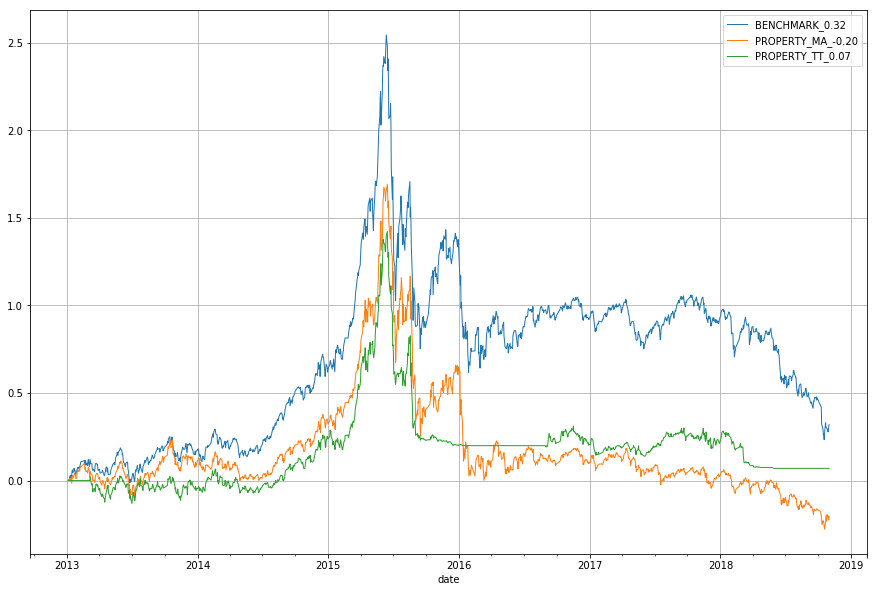

In [16]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# df = show_df.fillna(START_MONEY).copy()
df = show_df.dropna(how='any', inplace=False).copy()
df = df.loc[start_date:end_date]
df.drop(columns=['PROPERTY'], inplace=True)
df.columns

df['close'] = (df['close'] - df.iloc[0]['close']) / df.iloc[0]['close']
ax = df.plot(kind='line', y='close', label='BENCHMARK_%.2f' % df.iloc[-1]['close'], linewidth=1, grid=True)
for col in sorted(df.columns):
    if 'PROPERTY' in col:
        df[col] = (df[col] - df.iloc[1][col]) / df.iloc[0][col]
        ax = df.plot(kind='line', y=col, secondary_y=False, label='%s_%.2f' % (col, df.iloc[-1][col]), linewidth=1, grid=True, ax=ax)

# ax = df.plot(kind='line', y='close', label='BENCHMARK_%.2f' % df.iloc[-1]['close'], linewidth=1, grid=True)
# for col in sorted(df.columns):
#     if 'PROPERTY' in col:
#         df[col] = (df[col] - df.iloc[1][col]) / df.iloc[0][col]
#         ax = df.plot(kind='line', y=col, secondary_y=False, label='MA_%s_%.2f' % (col, df.iloc[-1][col]), linewidth=1, grid=True, ax=ax)

# display_charts(df, kind='line', figsize=(900, 600), logy=False)

In [17]:
df = show_df.dropna(how='any', inplace=False).copy()
df = df.loc[start_date:end_date]
df.drop(columns=['PROPERTY'], inplace=True)
# df.drop(columns=['PROPERTY_TT'], inplace=True)
df.columns

show_columns = ['close']
df['close'] = (df['close'] - df.iloc[0]['close']) / df.iloc[0]['close']
for col in sorted(df.columns):
    if 'PROPERTY' in col:
        df[col] = (df[col] - df.iloc[1][col]) / df.iloc[0][col]
        show_columns.append(col)
#     if 'CASH' in col:
#         df[col] = df[col] / df.iloc[0][col]
#         show_columns.append(col)
        
# df['unused'] = df['CASH'] / df['PROPERTY_TT']
# df = df.loc['20070101':]
# show_columns = ['unused']
# show_columns.append('unused')

df = df.loc[:, show_columns]
df.reset_index(drop=False, inplace=True)
df['date'] = df['date'].apply(lambda x: x.to_timestamp().to_datetime64())
df.set_index(keys=['date'], inplace=True)

# display_charts(df, chart_type='stock', figsize=(900, 600), logy=False)

Index(['open', 'close', 'o_pct_chg', 'c_o_pct_chg', 'ROLLING_60_MAX',
       'ROLLING_20_MIN', 'MA180', 'MA90', 'MA60', 'MA30', 'MA10', 'CASH',
       'PROPERTY_TT', 'PROPERTY_MA'],
      dtype='object')

In [18]:
# symbol = '399300'
# df = stock_df_dict[symbol].copy()
# df = df.loc[start_date:end_date]
# # df = df.loc[:, show_columns]
# df.reset_index(drop=False, inplace=True)
# df['date'] = df['date'].apply(lambda x: x.to_timestamp().to_datetime64())
# df.dtypes
# df.set_index(keys=['date'], inplace=True)

# display_charts(df, chart_type='stock', y=['open'], figsize=(900, 400))

In [19]:
# %matplotlib inline

# import matplotlib
# import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [16, 6]

# df = order_df.copy()
# df.drop(columns=['sell_reason'], inplace=True)
# df['pro_pct'] = (df.sell_price - df.buy_price) / df.buy_price

# # df = df.astype(dtype={'sell_date': 'datetime64[ns]', 'buy_date': 'datetime64[ns]', 'cash':'int'})
# df = df.astype(dtype={'cash': 'int', 'profit': 'int'})
# df['h_days'] = (df.sell_date - df.buy_date)
# df['h_days'] = df['h_days'].apply(lambda x: 1 if x == 0 else x)
# df['per_d'] = df.pro_pct / df.h_days * 365
# # df['per_d'] = df.apply(lambda x: x.pro_pct / x.h_days)

# df = df.loc[:, ['symbol', 'pro_pct']]
# df = df.groupby(by='symbol').sum()
# df = df.sort_values(by='pro_pct', ascending=False)
# # df.sort_values(by='pro_pct', ascending=False).head(5)
# # df.sort_values(by='pro_pct', ascending=False).tail(5)
# len(df)

# temp_df = df.copy()
# symbol_list = list(temp_df.index)
# # symbol_list = list(reversed(symbol_list))
# # for symbol in symbol_list[:3] + symbol_list[:1]:
# for symbol in symbol_list[:]:
#     symbol_df = stock_df_dict[symbol].copy()
#     symbol_df = symbol_df.loc[start_date:, ['open', 'MA10', 'MA60']]
#     symbol_df = symbol_df.iloc[2000:]
#     ax = symbol_df.plot(kind='line', title='%s %.2f' % (symbol, temp_df.loc[symbol].pro_pct), linewidth=0.7, grid=True)
# #     df = ops_df.copy()
# #     df = df[df.symbol == symbol]
# #     scatter_df = df[df.ops == 'BUY']
# #     plt.scatter(x=scatter_df['ops_date'], y=scatter_df['price'], color='BLUE', alpha=0.9)
# #     scatter_df = df[df.ops == 'SELL']
# #     plt.scatter(x=scatter_df['ops_date'], y=scatter_df['price'], color='RED', alpha=0.9)